In [ ]:
!unzip '/content/drive/MyDrive/Fiverr_Clients_Dataset/ECG Data/MyocardialData.zip'

## **1. Image Augmentation**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Set the path to your original images
original_data_dir = '/content/MyocardialData/Normal'

# Set the path to the folder where augmented images will be saved
augmented_data_dir = '/content/MyocardialData/Normal'

# Create the augmented data generator
augmentation_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Get the list of image filenames in the original folder
image_filenames = os.listdir(original_data_dir)

# Create the output folder if it doesn't exist
os.makedirs(augmented_data_dir, exist_ok=True)

# Loop through each image and apply augmentation
for filename in image_filenames:
    img_path = os.path.join(original_data_dir, filename)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images
    i = 0
    for batch in augmentation_datagen.flow(x, batch_size=1, save_to_dir=augmented_data_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= 2:  # Adjust the number of augmented images per original image as needed
            break

## **2. Training Pre-Trained Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the paths to your data folders
train_data_dir = '/content/MyocardialData'
train_normal_dir = 'Normal'
train_myocardial_dir = 'Myocardial Infarction Patients'

# Set the image size and batch size
img_size = (224, 224)
batch_size = 64

# Use data augmentation for better generalization
train_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle = True
)

# Create validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle = False
)

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build your own model on top of ResNet50
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size, verbose = 0
)

# Save the model
model.save('ecg_resnet_model.h5')

## **3. Evaluation Phase**

### **3.1 Test Accuracy & Test Loss**

In [ ]:
# Evaluate the model on the test set
evaluation = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)

print(f"Test Accuracy: {evaluation[1]*100:.2f}%")
print(f"Test Loss: {evaluation[0]:.4f}")

### **3.2 Train VS Validation Accuracy and Loss Plots**

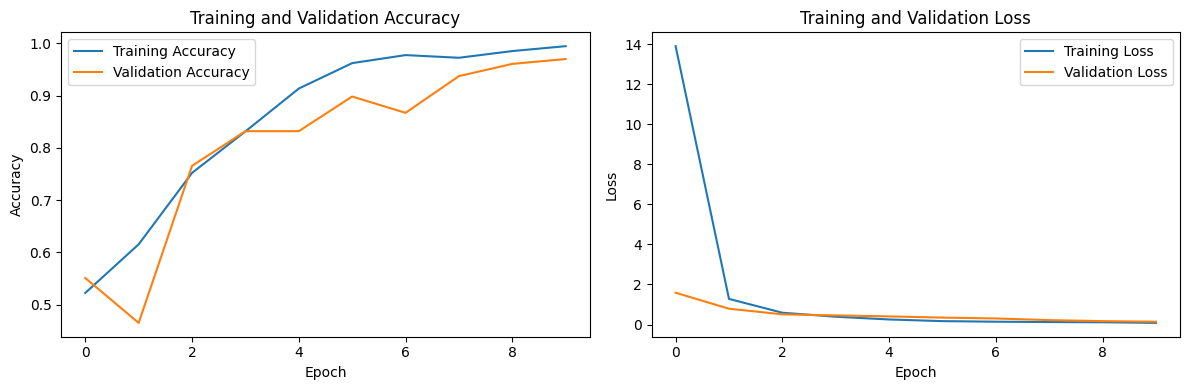

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **3.3 Classification Report**

In [ ]:
# Make predictions on the test set
y_true = validation_generator.classes
predict = model.predict_generator(validation_generator)
y_pred = (predict > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

<ipython-input-10-5950ee4e6ac9>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(validation_generator)
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       141
           1       0.95      0.96      0.96       166

    accuracy                           0.97       307
   macro avg       0.97      0.96      0.97       307
weighted avg       0.96      0.96      0.96       307


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the pre-trained model
#model = load_model('ecg_resnet_model.h5')

def predict_label(image_path):
    # Load and preprocess the input image
    img = image.load_img(image_path, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)

    print(predictions)

    y_pred = (predictions > 0.5).astype(int)

    if y_pred == 0:
      print('Prediction: Myocardial')
    else:
      print('Prediction: Normal')

# Example usage
image_path = '/content/MyocardialData/Myocardial Infarction Patients/aug_0_4123.jpg'
predicted_label = predict_label(image_path)

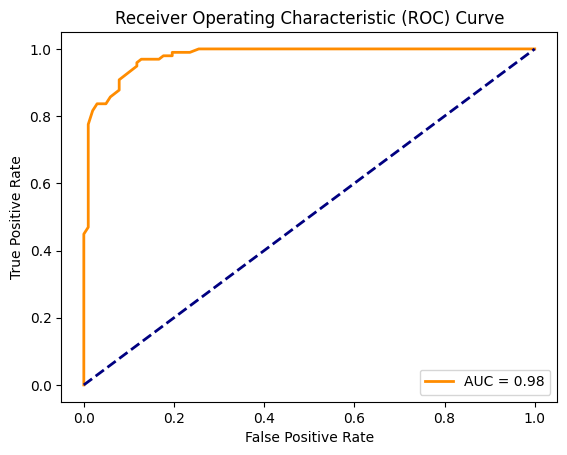

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_true = validation_generator.classes
y_pred_prob = model.predict_generator(validation_generator)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()